# Visual Multiple Choice Question Answering

### How to run the code ?
Set the variable `IS_TEST` to 
- `False` if you want to train a new model for VQA,
- `True` if you want to test a pretrained model. You can specify the path of the model you want to evaluate in `MODEL_PATH`.

To tune other parameters, have a look at the class `Config`.

In [1]:
IS_TEST = True
MODEL_PATH = 'vqa_part2-epoch65-val_loss2252.27.ckpt'#'vqa_part2-epoch47-val_loss2254.96.ckpt'#'vqa_part2-epoch45-val_loss1108.22.ckpt'#'vqa_part2-epoch29-val_loss2283.25.ckpt'#'vqa_part2-epoch15-val_loss849.46.ckpt'#'vqa_part2-epoch29-val_loss2283.25.ckpt'#'vqa_part2-epoch23-val_loss588.86.ckpt'#'vqa_part2-epoch27-val_loss1148.45-v1.ckpt'#'vqa_part2-epoch27-val_loss1294.40.ckpt'#'vqa_part2-epoch05-val_loss12.78.ckpt'

## Google Colab

In [2]:
GOOGLE_COLAB = True #False
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My Drive/sportsVQA
else:
    %cd sportsVQA

!pip install wandb --quiet

Mounted at /content/gdrive
/content/gdrive/My Drive/sportsVQA
     |████████████████████████████████| 1.8 MB 35.4 MB/s 
     |████████████████████████████████| 145 kB 71.8 MB/s 
     |████████████████████████████████| 181 kB 75.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


## Load Librairies

In [3]:
# OS
import os

# Arrays
import numpy as np

# Plots
from matplotlib import pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# OpenCV
import cv2

# Data Augmentation
!pip install albumentations==0.4.6 --quiet
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Transformers
!pip install transformers --quiet
import transformers as ppb

# Visualize Images
from IPython.display import Image, display

# Fast Training 
!pip install pytorch-lightning --quiet
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import BackboneFinetuning, StochasticWeightAveraging, ModelCheckpoint, LearningRateMonitor

# Progress bar
from tqdm.notebook import tqdm 

# Randomisation
import random

# For reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(SEED)

     |████████████████████████████████| 117 kB 34.4 MB/s 
     |████████████████████████████████| 948 kB 56.2 MB/s 
     |████████████████████████████████| 4.2 MB 17.2 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████| 6.6 MB 36.8 MB/s 
     |████████████████████████████████| 584 kB 30.3 MB/s 
     |████████████████████████████████| 140 kB 70.1 MB/s 
     |████████████████████████████████| 409 kB 78.5 MB/s 
     |████████████████████████████████| 1.1 MB 59.0 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 64.8 MB/s 
     |████████████████████████████████| 144 kB 76.1 MB/s 


## General Config

In [4]:
class Config:
    # ---- Reproducibility ---- 
    SEED = SEED
    
    # ----  Directories & Files ---- 
    VQA_PATH = 'vqa_with_bert_embeddings.pth'
    IMAGE_FEATURES_PATH = 'image_features.pth'
    MODEL_DIR = 'models/' # Path where the model is saved
    IMAGE_DIR = 'images/' # Path where the images are
    IMAGE_FORMAT = 'jpg'

    # ---- Logger ----
    USE_LOGGER = True
    if USE_LOGGER:
      LOGGER_KEY = "cd14f8bcc3118f1302a97c826fdb1c294732181a"
      LOGGER_PROJECT_NAME = "vqa-part2"
    
    # ---- Experiment ----
    DESCRIPTION = "Fusion by outer product" # Comment on the training

    # ---- Image ----
    IMAGE_SIZE = 60
    IMAGE_CHANNELS = 3
    IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
    IMAGE_MEAN = [0.485, 0.456, 0.406] # Mean of ImageNet
    IMAGE_STD = [0.229, 0.224, 0.225] # Std of ImageNet

    
    # ---- Training ----
    MAX_EPOCHS = 40 # Maximal number of epochs (influence SWA callback !)
    WEIGHT_DECAY = 1e-5#1e-4 # L2 Regularization
    NORM_CLIPPING = 0.015 # Clip the gradient norm to prevent gradient explosion
    BATCH_SIZE = 512
    LR = 1e-3 # Learning Rate
    NUM_WORKERS = 4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ACCELERATOR = 'gpu' if torch.cuda.is_available() else 'cpu'
    PRECISION = 16 # 16-bit precision rather than 32-bit (at least 2x faster, even more if GPU optimised for 16-bit precision)
    COSINE_ANNEALING_WARM_RESTARTS = True # Whether to use the cosine annealing warm restart scheduler
    STOCHASTIC_WEIGHT_AVERAGING = False # Whether to use stochastic weight averaging during the last epochs

    # ---- Cosine Annealing Warm Restarts ----
    #if COSINE_ANNEALING_WARM_RESTARTS:
    CAWR_T0 = 20 # Period of the cosine annealing warm restart scheduler
    CAWR_T_MULT = 1#2 # Multiplier applied to increase the period during training
    CAWR_MIN_LR = 1e-5#1e-6 # Minimum learning rate that the scheduler is allowed to reach
    
    # ---- Stochastic Weight Averaging ----
    #if STOCHASTIC_WEIGHT_AVERAGING:
    SWA_EPOCH_START = 140 #SWA_EPOCH_START-th epoch, start SWA  #OR: #0.80 # At (SWA_EPOCH_START * max_epoch)-th epoch, start SWA
    SWA_LR = LR / 10 # Learning rate to start SWA
    SWA_ANNEALING_EPOCHS = 20#10 #5 # Number of epochs in the annealing phase

    # ---- Model ----
    SAVE_MODEL = True # Whether to save the model weights in Logger
    MODEL_NAME = 'vqa_part2'
    IMAGE_DIM = 2048 # Dimension of the image features
    TEXT_DIM = 768 # Dimension of the text features
    USE_FC = True # whether to add a classifier made of fc layers on top of the backbone
    #if USE_FC:
    DROPOUT = 0.1 
    FC_IMAGE_DIM = 64 # Dimension at the output of the fully connected layer for the image emdeddings
    FC_TEXT_DIM = 64 # Dimension at the output of the fully connected layer for the text emdeddings
    ACTIVATION = None
    
    # ---- Loss ----
    TRIPLET_LOSS_MARGIN = 1000

    # ---- Testing ----
    IS_TEST = IS_TEST
    MODEL_PATH = MODEL_DIR + MODEL_PATH

Save config to Logger

In [5]:
if not Config.IS_TEST and Config.USE_LOGGER:
    from pytorch_lightning.loggers import WandbLogger
    import wandb
    
    params = {
    'seed': Config.SEED,
    'max_epochs': Config.MAX_EPOCHS,
    'batch_size': Config.BATCH_SIZE,
    'lr': Config.LR,
    'triplet_loss_margin': Config.TRIPLET_LOSS_MARGIN,
    'image_shape': Config.IMAGE_SHAPE,
    }

    if Config.WEIGHT_DECAY > 0.0:
        params.update({'weight_decay': Config.WEIGHT_DECAY})

    if Config.DESCRIPTION != '':
        params.update({'description': Config.DESCRIPTION})

    if Config.NORM_CLIPPING < 1.0:
        params.update({'norm_clipping': Config.NORM_CLIPPING})

    if Config.USE_FC:
        params.update({
            'use_fc': Config.USE_FC,
            'dropout': Config.DROPOUT,
        })

    if Config.ACTIVATION != None:
        params.update({'activation': Config.ACTIVATION})

    if Config.COSINE_ANNEALING_WARM_RESTARTS:
        params.update({
                'cawr_T0': Config.CAWR_T0,
                'cawr_T_mult': Config.CAWR_T_MULT,
                'cawr_min_lr': Config.CAWR_MIN_LR,
        })

    if Config.STOCHASTIC_WEIGHT_AVERAGING:
        params.update({
            'swa_epoch_start': Config.SWA_EPOCH_START,
            'swa_lrs': Config.SWA_LR,
            'swa_annealing_epochs': Config.SWA_ANNEALING_EPOCHS,
        })

    logger = WandbLogger(project = Config.LOGGER_PROJECT_NAME)
    logger.experiment.config["key"] = Config.LOGGER_KEY

    # Save model parameters manually
    logger.experiment.config.update(params)
else:
  logger = True

## Pytorch Lightning Callbacks

In [6]:
if not Config.IS_TEST:
    # Choose callbacks
    callbacks = []
        
    if Config.STOCHASTIC_WEIGHT_AVERAGING:
        # Stochastic Weight Averaging is a very efficient approach to obtain more generalizable model (better test error)
        # source: https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
        SWA_callback = StochasticWeightAveraging(
            swa_epoch_start=Config.SWA_EPOCH_START, 
            swa_lrs=Config.SWA_LR, 
            annealing_epochs=Config.SWA_ANNEALING_EPOCHS,
        )
        callbacks.append(SWA_callback)
        
    if Config.COSINE_ANNEALING_WARM_RESTARTS:
        lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')
        callbacks.append(lr_monitor_callback)
        
    if Config.SAVE_MODEL:
        filename_prefix = f'{Config.MODEL_NAME}'
        
        # Checkpoint the model at each epoch where the <val_loss> improves
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath=Config.MODEL_DIR,    
            filename=filename_prefix + '-epoch{epoch:02d}-val_loss{val_loss:.2f}',
            save_top_k=1, # Save the best model
            save_last=True, # Save the last model
            save_weights_only=True,
            mode='min',
            auto_insert_metric_name=False
        )
        callbacks.append(checkpoint_callback)

## Load Data

In [7]:
from dataset import create_vqa_datasets

train_set, validation_set, test_set = create_vqa_datasets(Config.VQA_PATH, Config.IMAGE_FEATURES_PATH, part2=True)

loading datafiles...
loading datafiles done!


In [8]:
#print(len(train_set)) # 33000 

In [9]:
#print(len(validation_set)) # 3000

In [10]:
#print(len(test_set)) # 3000

In [11]:
class VisualMCQDataset(Dataset):
    def __init__(self, dataset, train=False, num_negative_examples_per_question=8):
        super().__init__()
        self.dataset = dataset
        self.train = train
        if train:
          self.num_negative_examples_per_question = num_negative_examples_per_question

        self.wrong_choices = []
        for i in range(len(self.dataset)):
          answer = self.dataset[i]['answer']
          self.wrong_choices.append([])
          for choice in self.dataset[i]['multiple_choices']:
            if choice != answer: # we only save wrong answers
              if (not train) or (choice not in self.wrong_choices[i]): # in training mode, we do not keep duplicates
                self.wrong_choices[i].append(choice)

        # self.transform = A.Compose([A.Resize(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
        #                             A.Normalize(Config.IMAGE_MEAN, Config.IMAGE_STD),
        #                             ToTensorV2()
        #                             ])

    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self, idx):
        # # Load image
        # image_path = os.path.join(Config.IMAGE_DIR, str(self.dataset[idx]['image_id']) + '.' + Config.IMAGE_FORMAT)
        # # print(image_path)
        # image = cv2.imread(image_path)
        # # By default OpenCV uses BGR color space for color images,
        # # so we need to convert the image to RGB color space.
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        # if self.transform:
        #   augmented = self.transform(image=image)
        #   image = augmented['image']

        # image = self.images[idx]
        image = self.dataset[idx]['image_features']
        question = self.dataset[idx]['sentence_representation']
        multiple_choices = self.wrong_choices[idx]
        answer = self.dataset[idx]['answer']
        
        if self.train:
          # we select at random num_negative_examples_per_question without replacement
          random_multiple_choices = np.random.choice(multiple_choices, self.num_negative_examples_per_question, replace=False) 
          return [(image, question), (image, answer), [(image, random_choice) for random_choice in random_multiple_choices]]
        return [(image, question), (image, answer), [(image, choice) for choice in multiple_choices]]

In [12]:
if Config.IS_TEST:
  mcq_test_set = VisualMCQDataset(test_set, train=False)
  test_loader = DataLoader(mcq_test_set, 
                           batch_size=50,
                           num_workers=Config.NUM_WORKERS, 
                           shuffle=False,
                           pin_memory=True, 
                           drop_last=False,)
else:
  mcq_train_set = VisualMCQDataset(train_set, train=True)
  mcq_validation_set = VisualMCQDataset(validation_set, train=True)

  train_loader = DataLoader(mcq_train_set, 
                            batch_size=Config.BATCH_SIZE, 
                            num_workers=Config.NUM_WORKERS,
                            shuffle=True,
                            pin_memory=True, 
                            drop_last=True,)
  
  validation_loader = DataLoader(mcq_validation_set, 
                                 batch_size=50,
                                 num_workers=Config.NUM_WORKERS,
                                 shuffle=False, 
                                 pin_memory=True, 
                                 drop_last=True,)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def euclidean_distance(x, y, batch=True):
  return torch.sqrt(((x - y)**2).sum(axis=tuple(range(batch, x.ndim))))

def answer_accuracy(positive_dist, negatives_dist, batch=True):
  return torch.mean((torch.sum(negatives_dist < positive_dist, dim=0) == 0).type(torch.DoubleTensor))

def answer_mean_rank_ratio(positive_dist, negatives_dist, batch=True):
  return torch.mean((torch.sum(negatives_dist < positive_dist, dim=0) + 1).type(torch.DoubleTensor)) 

In [14]:
class TextModel(pl.LightningModule):
  def __init__(
      self,
      in_dim = Config.TEXT_DIM,
      use_fc = Config.USE_FC,
      fc_dim = Config.FC_TEXT_DIM,
      dropout = Config.DROPOUT,
      activation = Config.ACTIVATION,
      ):
    
      self.save_hyperparameters()

      super(TextModel, self).__init__()

      # Load pretrained model/tokenizer
      model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
      self.tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
      self.pretrained_model = model_class.from_pretrained(pretrained_weights).to(Config.DEVICE)#.eval()
      for param in self.pretrained_model.parameters(): # Fix bert parameters, we will not tune them
          param.requires_grad = False

      self.use_fc = use_fc

      if use_fc:
          self.fc = nn.Linear(in_dim, fc_dim)
          self.dropout = nn.Dropout(p=dropout)

      self.activation = activation
      if self.activation != None:
          self.activation = getattr(F, activation)

      self.init_params()

  def init_params(self):
      nn.init.xavier_normal_(self.fc.weight)
      nn.init.constant_(self.fc.bias, 0)

  def extract_bert_embeddings(self, x):
      x = self.tokenizer.encode(x, add_special_tokens=False)
      x = torch.tensor(x).long().unsqueeze(1).to(Config.DEVICE)
      last_hidden_states = self.pretrained_model(x)[1].to(Config.DEVICE)
      sentence_representations = last_hidden_states
      return sentence_representations
  
  def forward(self, 
              batch):
      if isinstance(batch[0], str): 
          # if the input is not in the form of strings 
          # instead of numerical embeddings,
          # extract its embeddings
          batch = self.extract_bert_embeddings(batch)
      features = self.extract_feat(batch)
      return features

  def extract_feat(self, x):
    if self.use_fc:
        x = self.fc(x)
        x = self.dropout(x)

    if self.activation != None:
        x = self.activation(x)

    return x


# class AnswerModel(pl.LightningModule):
#   def __init__(
#       self,
#       in_dim = Config.TEXT_DIM,
#       use_fc = Config.USE_FC,
#       fc_dim = Config.FC_TEXT_DIM,
#       dropout = Config.DROPOUT,
#       activation = Config.ACTIVATION,
#       ):
    
#       self.save_hyperparameters()

#       super(AnswerModel, self).__init__()

#       # Load pretrained model/tokenizer
#       model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
#       self.tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#       self.pretrained_model = model_class.from_pretrained(pretrained_weights).to(Config.DEVICE).eval()

#       self.use_fc = use_fc

#       if use_fc:
#           self.fc = nn.Linear(in_dim, fc_dim)
#           self.dropout = nn.Dropout(p=dropout)

#       self.activation = activation
#       if self.activation != None:
#           self.activation = getattr(F, activation)

#       self.init_params()

#   def init_params(self):
#       nn.init.xavier_normal_(self.fc.weight)
#       nn.init.constant_(self.fc.bias, 0)
  
#   def forward(self, 
#               batch):
#       features = self.extract_feat(batch)
#       return features

#   def extract_bert_embedding(self, x):
#     x = self.tokenizer.encode(x, add_special_tokens=True)
#     x = torch.tensor(x).long().unsqueeze(0).to(Config.DEVICE)#.cuda()
#     # with torch.no_grad():
#     last_hidden_states = self.pretrained_model(x)[0].squeeze(0)#.cpu()

#     sentence_representation = last_hidden_states[0]
#     # word_representations = last_hidden_states[1:]
#     return sentence_representation#, word_representations

#   def extract_feat(self, x):
#     x = self.extract_bert_embedding(x)
#     if self.use_fc:
#         x = self.fc(x)
#         x = self.dropout(x)

#     if self.activation != None:
#         x = self.activation(x)

#     return x
  

class ImageModel(pl.LightningModule):
  def __init__(
      self,
      in_dim = Config.IMAGE_DIM,
      use_fc = Config.USE_FC,
      fc_dim = Config.FC_IMAGE_DIM,
      dropout = Config.DROPOUT,
      activation = Config.ACTIVATION,
      ):
    
      self.save_hyperparameters()

      super(ImageModel, self).__init__()

      self.pretrained_model = torchvision.models.resnet50(pretrained = False)
      self.pretrained_model.fc = torch.nn.Identity()
      for param in self.pretrained_model.parameters():
        param.requires_grad = False


      self.use_fc = use_fc
      if use_fc:
          self.fc = nn.Linear(in_dim, fc_dim)
          self.dropout = nn.Dropout(p=dropout)
          
      self.activation = activation
      if self.activation != None:
          self.activation = getattr(F, activation)

      self.init_params()

  def init_params(self):
      nn.init.xavier_normal_(self.fc.weight)
      nn.init.constant_(self.fc.bias, 0)
  
  def forward(self, 
              batch):
      # if there are at least 2 dimensions, we are in the presence of an image, 
      # otherwise we already have the 1-D vector of image features
      if batch[0].dim() >= 2:
        batch = self.pretrained_model(batch)
      features = self.extract_feat(batch)
      return features

  def extract_feat(self, x):
    if self.use_fc:
        x = self.fc(x)
        x = self.dropout(x)
    if self.activation != None:
        x = self.activation(x)
    return x


class VQAModel(pl.LightningModule):
  def __init__(
      self
      ):
    
      self.save_hyperparameters()

      super(VQAModel, self).__init__()

      self.image_to_features = {}
      for dataset in [train_set, validation_set, test_set]:
        for i in range(len(dataset)):
          self.image_to_features[dataset[i]['image_id']] = dataset[i]['image_features']

      self.image_model = ImageModel().to(Config.DEVICE)
      self.question_model = TextModel().to(Config.DEVICE)

  
  def forward(self, batch): 
      image_features, text_features = self.extract_feat(batch)

      # # Outer-product - size: (batch_size, fc_representation1_dim, fc_representation2_dim)
      # # Outer-produc between the question and answer representations
      # features = torch.bmm(question_features.unsqueeze(2), answer_features.unsqueeze(1)) 
      # # Flatten the result - size: (batch_size, fc_representation1_features * fc_representation2_dim)
      # features = torch.flatten(features, start_dim=1) 
      # # Outer-product between the image and question-answer representations
      # features = torch.bmm(image_features.unsqueeze(2), features.unsqueeze(1)) 
      # # Flatten the result - size: (batch_size, fc_representation1_features * fc_representation2_dim)
      # features = torch.flatten(features, start_dim=1) 

      # Outer-product - size: (batch_size, fc_representation1_dim, fc_representation2_dim)
      # Outer-product between the image and question/answer representations
      features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) 
      # Flatten the result - size: (batch_size, fc_representation1_features * fc_representation2_dim)
      features = torch.flatten(features, start_dim=1) 
      return features

  def extract_feat(self, batch):
      image_batch = batch[0]
      text_batch = batch[1]
      image_features = self.image_model(image_batch)
      text_features = self.question_model(text_batch)
      return image_features, text_features


  def training_step(self, train_batch, batch_idx):
      image_question = train_batch[0]
      image_answer = train_batch[1]
      image_choices = train_batch[2]

      anchor = self.forward(image_question)
      positive = self.forward(image_answer)
      positive_dist = euclidean_distance(anchor, positive)

      loss = 0
      negatives_dist = []
      for image_choice in image_choices:
        negative = self.forward(image_choice)
        loss += nn.TripletMarginLoss(margin=Config.TRIPLET_LOSS_MARGIN)(anchor, positive, negative)
        negatives_dist.append(euclidean_distance(anchor, negative))
      negatives_dist = torch.stack(negatives_dist, dim=0)

      accuracy = answer_accuracy(positive_dist, negatives_dist)
      logs = {'train_loss': loss, 'train_accuracy': accuracy}
      self.log_dict(logs, batch_size=Config.BATCH_SIZE, on_epoch=True)
      return loss

  def validation_step(self, val_batch, batch_idx):
      image_question = val_batch[0]
      image_answer = val_batch[1]
      image_choices = val_batch[2]

      anchor = self.forward(image_question)
      positive = self.forward(image_answer)
      positive_dist = euclidean_distance(anchor, positive)

      loss = 0
      negatives_dist = []
      for image_choice in image_choices:
        negative = self.forward(image_choice)
        loss += nn.TripletMarginLoss(margin=Config.TRIPLET_LOSS_MARGIN)(anchor, positive, negative)
        negatives_dist.append(euclidean_distance(anchor, negative))
      negatives_dist = torch.stack(negatives_dist, dim=0)
      
      accuracy = answer_accuracy(positive_dist, negatives_dist)
      logs = {'val_loss': loss, 'val_accuracy': accuracy}
      self.log_dict(logs, batch_size=Config.BATCH_SIZE)
      return loss

  def test_step(self, test_batch, batch_idx):
      image_question = test_batch[0]
      image_answer = test_batch[1]
      image_choices = test_batch[2]

      anchor = self.forward(image_question)
      positive = self.forward(image_answer)
      positive_dist = euclidean_distance(anchor, positive)

      negatives_dist = []
      for image_choice in image_choices:
        negative = self.forward(image_choice)
        negatives_dist.append(euclidean_distance(anchor, negative))
      negatives_dist = torch.stack(negatives_dist, dim=0)

      mean_rank_ratio = answer_mean_rank_ratio(positive_dist, negatives_dist) 
      accuracy = answer_accuracy(positive_dist, negatives_dist)
      logs = {'test_accuracy': accuracy, 'test_mean_rank_ratio': mean_rank_ratio}
      self.log_dict(logs, batch_size=Config.BATCH_SIZE)
      return accuracy
    
  def predict(self, image, question, multiple_choices):
      if isinstance(image, int):
        image = self.image_to_features[image]
      image = image.to(Config.DEVICE)
      if isinstance(question, str):
        anchor = self.forward((image.unsqueeze(0), [question]))
      else:
        question = question.to(Config.DEVICE)
        anchor = self.forward((image.unsqueeze(0), question.unsqueeze(0)))
      multiple_choices_representations = [self.forward((image.unsqueeze(0), [choice])) for choice in multiple_choices]
      dist = []
      for choice_representation in multiple_choices_representations:
        dist.append(euclidean_distance(anchor, choice_representation))
      dist = torch.stack(dist, dim=0)
      answer = multiple_choices[torch.argmin(dist)]
      return answer

  def configure_optimizers(self, 
                            lr=Config.LR, 
                            weight_decay=Config.WEIGHT_DECAY, 
                            T0=Config.CAWR_T0, 
                            T_mult=Config.CAWR_T_MULT, 
                            min_lr=Config.CAWR_MIN_LR):
      optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
      if Config.COSINE_ANNEALING_WARM_RESTARTS:
          scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult=T_mult, eta_min=min_lr, verbose=True)
          return [optimizer], [scheduler]

      return optimizer

if not Config.IS_TEST:
  model = VQAModel()

In [15]:
if not Config.IS_TEST:
    if Config.USE_LOGGER:
        # Log gradients, parameter histogram and model topology
        logger.watch(model, log="all")
      
    # Train the model
    trainer = pl.Trainer(gpus=-1,
                        accelerator = Config.ACCELERATOR, 
                        max_epochs=Config.MAX_EPOCHS,
                        callbacks=callbacks,
                        gradient_clip_val=Config.NORM_CLIPPING,
                        precision=Config.PRECISION,
                        log_every_n_steps=1,
                        logger=logger)
    trainer.fit(model, train_loader, validation_loader)

    if Config.SAVE_MODEL:
        if Config.USE_LOGGER:
            # Log model checkpoint to Logger
            print('All models saved: ')
            for k in checkpoint_callback.best_k_models.keys():
                print(k)
                model_name = k.split('/')[-1]
                logger.experiment.log_artifact(k, model_name, type="model")

        best_model_path = checkpoint_callback.best_model_path
        print("Best model path: ", best_model_path)

    if Config.USE_LOGGER:
        wandb.finish()

else:
    model = VQAModel.load_from_checkpoint(Config.MODEL_PATH)
    trainer = pl.Trainer(accelerator = Config.ACCELERATOR)
    trainer.test(model, dataloaders=test_loader)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. T

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3423333333333335
  test_mean_rank_ratio       2.844666666666667
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
# drive.flush_and_unmount()

## Qualitative Analysis on Test Set

In [ ]:
# from matplotlib.image import imread

# def show_samples(batch, predicted_labels=None, cols=5):
#     image_ids = batch["image_ids"]
#     questions = batch["questions"]
#     true_answers = batch["answers"]
#     if predicted_labels != None:
#         pred_answers = [["No", "Yes"][predicted_label] for predicted_label in predicted_labels]
#     rows = int(np.ceil(len(true_answers) / cols))
#     figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 12))
#     color = "black"
#     i = 0
#     for image_id, true_answer in zip(image_ids, true_answers):
#         title = true_answer
#         if predicted_labels != None:
#             title = pred_answers[i] + ' | ' + true_answer
#             color = "green" if pred_answers[i] == true_answer else "red"
#         image = imread(Config.IMAGE_DIR + str(image_id) + '.' + Config.IMAGE_FORMAT)
#         ax.ravel()[i].imshow(image)#np.transpose(image, (1, 2, 0)))
#         ax.ravel()[i].set_title(title, color=color)
#         ax.ravel()[i].set_axis_off()
#         i += 1
#     plt.tight_layout()
#     plt.show()

In [ ]:
# if Config.IS_TEST:
#   dataiter = iter(test_loader)
#   batch = dataiter.next()
#   show_samples(batch, cols=5)

In [ ]:
# if Config.IS_TEST:
#   model.eval()
#   dataiter = iter(test_loader)
#   batch = dataiter.next()
#   predicted_labels = model.predict(batch)
#   show_samples(batch, predicted_labels=predicted_labels, cols=5)

## Demo

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


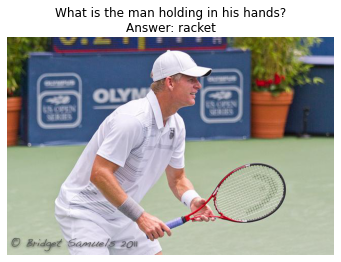

Question: What is the man holding in his hands?
Possible answers: 'racket', 'hat', 'ball', 'shoe', 'tree', 'shirt'
Chosen answer: racket


In [17]:
import os
from matplotlib import pyplot as plt

MODEL_PATH = 'vqa_part2-epoch65-val_loss2252.27.ckpt'
model = VQAModel.load_from_checkpoint(Config.MODEL_PATH).to(Config.DEVICE)

# TODO: Change the following line so that the resulting path points to the directory that
#       contains the test images.
test_images_path = Config.IMAGE_DIR
# TODO: Change the following line so that the resulting path points to the file that
#       contains the demo queries.
path =  'example2.txt'
with open(path) as file:
    lines = []
    for line in file:
        line = line.rstrip()
        if line:
            lines.append(line)
        else:
            image_name, question, *answers = lines

            image_id = int(image_name[:-len(Config.IMAGE_FORMAT)-1])
            
            chosen_answer = model.predict(image_id, question, answers)
            

            # TODO: At this point, you should place code that answers the visual question.
            #       The variables image_name and question contain the filename of the
            #       image and the question to be answered. The variable answers is either
            #       an empty list, in which case you need to answer Yes or No (part I),
            #       or a list with the possible answers (part II), in which case you
            #       need to select one of them. Make sure to write the answer you choose
            #       in the variable chosen_answer.
            

            image_path = os.path.join(test_images_path, image_name)
            image = plt.imread(image_path)
            plt.imshow(image)
            plt.title(question + f'\nAnswer: {chosen_answer}')
            plt.axis('off')
            plt.show()
            print(f'Question: {question}')
            if answers:
                print(f'Possible answers: {str(answers)[1:-1]}')
            print(f'Chosen answer: {chosen_answer}')
            #input('Press ENTER to continue...\n')
            lines = []


## Qualitative Analysis on Test Set

In [18]:
model = VQAModel.load_from_checkpoint(Config.MODEL_PATH).to(Config.DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'racket'

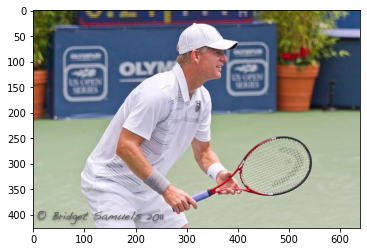

In [19]:
image_str = '278744.jpg'
image = cv2.imread(Config.IMAGE_DIR + image_str)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)

image_id = int(image_str[:-len(Config.IMAGE_FORMAT)-1])
question = 'What is the man holding in his hands?'
multiple_choices = ['racket', 'hat', 'ball', 'shoe', 'tree', 'shirt']
model.predict(image_id, question, multiple_choices)

'no'

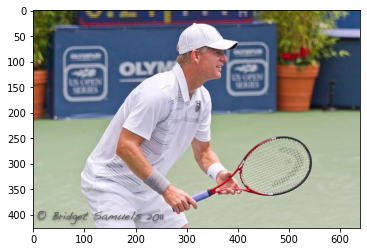

In [20]:
image_str = '278744.jpg'
image = cv2.imread(Config.IMAGE_DIR + image_str)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)

image_id = int(image_str[:-len(Config.IMAGE_FORMAT)-1])
question = 'Is this man wearing a hat?'
multiple_choices = ['yes', 'no']
model.predict(image_id, question, multiple_choices)

Question: What sport is this?
Choices:  ['2', 'it has eyes', '3', 'receding', 'green', 'white', 'blue', 'soccer', '1', 'months', 'picture', 'no', 'tennis', 'red', 'volleyball', '4', 'yes', 'baseball']
Answer:  baseball


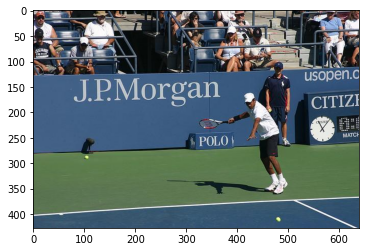

In [ ]:
i=100
dataset = test_set
image_str = '{}.jpg'.format(dataset[i]['image_id'])
image = cv2.imread(Config.IMAGE_DIR + image_str)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)

image_id = int(image_str[:-len(Config.IMAGE_FORMAT)-1])
question = dataset[i]['question']
multiple_choices = dataset[i]['multiple_choices']#['yes', 'no']#, 'racket', 'hat', 'ball', 'shoe', 'tree', 'shirt']
print("Question:", question)
print("Choices: ", multiple_choices)
question_representations = dataset[i]['sentence_representation']
print("Answer: ", model.predict(image_id, question_representations, multiple_choices))